<a href="https://colab.research.google.com/github/amir-asari/Qwen-VL-Basic/blob/main/Qwen_Zeroshot_ImgClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

### --- 1. Environment Setup and Installation ---
This block installs/upgrades libraries and forces a runtime restart.

This ensures bitsandbytes loads correctly for 4-bit quantization.


In [1]:
print("Installing necessary packages...")


!pip install -q git+[https://github.com/huggingface/transformers.git](https://github.com/huggingface/transformers.git) accelerate
!pip install -q -U bitsandbytes
!pip install -q qwen-vl-utils pillow








Installing necessary packages...
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install -q git+[https://github.com/huggingface/transformers.git](https://github.com/huggingface/transformers.git) accelerate'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.5 MB/s eta 0:00:00


### --- 2. Imports and Model Loading (with 4-bit Quantization) ---

In [2]:
import torch
import warnings
import random # Added for sampling the dataset
from PIL import Image
from datasets import load_dataset # Added for loading CIFAR-100
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, BitsAndBytesConfig

# --- NEW IMPORTS for Metrics and Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# ---------------------------------------------

# Suppress minor warnings for a clean output
warnings.filterwarnings('ignore')

# Switched to the smaller 3B model for compatibility and speed on T4 GPUs.
MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"

# Check for GPU availability
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"--- Environment Setup ---")
print(f"Device: {device}")
print(f"Loading Model: {MODEL_ID} (with 4-bit Quantization)")
print("-" * 50)

model = None
try:
    # 1. Define 4-bit quantization configuration
    # This is the key to preventing CUDA Out of Memory errors
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )

    # 2. Load the Model and Processor
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    processor = AutoProcessor.from_pretrained(MODEL_ID)

    # Load model using the 4-bit configuration
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        torch_dtype=dtype,
        device_map="auto",
    ).eval()
    print("Model loaded successfully in 4-bit precision.")

except Exception as e:
    print(f"Error loading model or libraries: {e}")
    print("Please ensure you have a T4 GPU enabled and the runtime has been restarted after installation.")
    model = None

--- Environment Setup ---
Device: cuda
Loading Model: Qwen/Qwen2.5-VL-3B-Instruct (with 4-bit Quantization)
--------------------------------------------------


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


chat_template.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

Model loaded successfully in 4-bit precision.


### --- 3. Zero-Shot Classification Function ---

In [3]:
def zero_shot_classify(image: Image.Image, candidate_labels: list):
    """
    Performs zero-shot classification by generating a prompt that includes the
    list of candidate labels (VQA format) for the provided PIL Image object.
    """
    if model is None:
        return "Model failed to load. Cannot run inference."

    labels_str = ", ".join([f"'{label}'" for label in candidate_labels])

    # The classification prompt is framed as a VQA task
    question = (
        f"What is the most accurate classification of the object shown in this image? "
        f"Choose only one answer from the following candidates: {labels_str}. State only the chosen label."
    )

    # 1. Define the conversation with a mandatory SYSTEM prompt
    conversation = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": "You are a highly efficient image classifier. Your only task is to output the single, most relevant label from the provided candidates. Do not use any conversational text or formatting."}
            ],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": question}
            ],
        }
    ]

    # 2. Process the input and generate response
    try:
        inputs = processor.apply_chat_template(
            conversation,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt"
        ).to(device)

        # Generate response
        output_ids = model.generate(
            **inputs,
            do_sample=False,
            max_new_tokens=20, # Only need a short output (the chosen label)
        )

        response_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # --- FIX: Robustly clean the output from Qwen chat tags ---
        assistant_marker = "\nassistant\n"

        if assistant_marker in response_text:
            response_text = response_text.split(assistant_marker)[-1]

        # Final cleanup for any leftover text or whitespace.
        response_text = response_text.strip()

        return response_text

    except Exception as e:
        # Catch and report CUDA OOM or other inference errors
        return f"Error during model inference: {e}"

### --- 4. CIFAR-10 Dataset Loading and Execution ---


--- Loading CIFAR-10 Dataset (Test Split) ---
Total CIFAR-10 Test Images: 10000
Number of Candidate Labels: 10
Candidate Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Sampling complete. Total samples for testing: 5000

--- Starting Zero-Shot Classification (Displaying first 5 samples) ---
0

[CIFAR-10 Sample 1 / 5000]
Expected Label: airplane


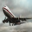

Predicted Label: airplane
Result: CORRECT
--------------------------------------------------
1

[CIFAR-10 Sample 2 / 5000]
Expected Label: airplane


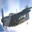

Predicted Label: airplane
Result: CORRECT
--------------------------------------------------
2

[CIFAR-10 Sample 3 / 5000]
Expected Label: airplane


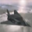

Predicted Label: airplane
Result: CORRECT
--------------------------------------------------
3

[CIFAR-10 Sample 4 / 5000]
Expected Label: airplane


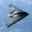

Predicted Label: airplane
Result: CORRECT
--------------------------------------------------
4

[CIFAR-10 Sample 5 / 5000]
Expected Label: airplane


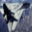

Streaming output truncated to the last 5000 lines.
Result: CORRECT
--------------------------------------------------
5

...Continuing silent classification for remaining 4995 samples...
Final performance metrics will be calculated over the entire sampled dataset.
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
2

In [9]:
print("\n--- Loading CIFAR-10 Dataset (Test Split) ---")
# Load the test split of CIFAR-10
dataset = load_dataset('cifar10', split='test')

# Extract the 10 class names to use as candidate labels
candidate_labels = dataset.features['label'].names
label_to_id = {name: i for i, name in enumerate(candidate_labels)}

print(f"Total CIFAR-10 Test Images: {len(dataset)}")
print(f"Number of Candidate Labels: {len(candidate_labels)}")
print(f"Candidate Labels: {candidate_labels}")

# --- NEW: Implement Per-Class Sampling Logic ---
SAMPLES_PER_CLASS = 500
random.seed(42) # Ensure reproducibility

# Group indices by class ID
class_indices = {i: [] for i in range(len(candidate_labels))}
for i, item in enumerate(dataset):
    class_indices[item['label']].append(i)

# Select 50 random samples from each class
selected_indices = []
for label_id in class_indices:
    if len(class_indices[label_id]) >= SAMPLES_PER_CLASS:
        selected_indices.extend(random.sample(class_indices[label_id], SAMPLES_PER_CLASS))
    else:
        # Fallback if a class has fewer than 50 samples (not an issue for CIFAR-10)
        selected_indices.extend(class_indices[label_id])

total_samples = len(selected_indices)
print(f"\nSampling complete. Total samples for testing: {total_samples}")

# --- Starting Classification Loop ---
print("\n--- Starting Zero-Shot Classification (Displaying first 5 samples) ---")

all_expected_labels = []
all_predicted_labels = []
correct_predictions = 0
display_limit = 5

for index, dataset_index in enumerate(selected_indices):
    item = dataset[dataset_index]

    image_pil = item['img']
    expected_label = candidate_labels[item['label']]

    # Perform classification
    predicted_label = zero_shot_classify(image_pil, candidate_labels)

    # Check for correctness (case-insensitive)
    is_correct = predicted_label.lower() == expected_label.lower()

    if is_correct:
        correct_predictions += 1

    # Store results for final metrics calculation
    all_expected_labels.append(expected_label)
    all_predicted_labels.append(predicted_label)

    print(index)


    # Only print detailed results and display image for the first N samples
    if index < display_limit:
        print(f"\n[CIFAR-10 Sample {index+1} / {total_samples}]")
        print(f"Expected Label: {expected_label}")
        display(image_pil)
        print(f"Predicted Label: {predicted_label}")
        print(f"Result: {'CORRECT' if is_correct else 'INCORRECT'}")
        print("-" * 50)
    elif index == display_limit:
        # Print a message once to indicate the loop is continuing without display
        print(f"\n...Continuing silent classification for remaining {total_samples - display_limit} samples...")
        print("Final performance metrics will be calculated over the entire sampled dataset.")


### --- 5. Performance Metrics ---



--- 5. Performance Metrics ---
Total Samples Tested (50 per class): 5000
Correct Predictions:  4111
Zero-Shot Accuracy:   82.22%

--- Classification Report ---
              precision    recall  f1-score   support

    airplane       0.71      0.89      0.79       500
  automobile       0.72      0.98      0.83       500
        bird       0.87      0.84      0.86       500
         cat       0.82      0.74      0.77       500
        deer       0.96      0.72      0.82       500
         dog       0.69      0.80      0.74       500
        frog       0.88      0.79      0.83       500
       horse       0.91      0.88      0.90       500
        ship       0.99      0.74      0.85       500
       truck       0.91      0.84      0.88       500

   micro avg       0.83      0.82      0.83      5000
   macro avg       0.85      0.82      0.83      5000
weighted avg       0.85      0.82      0.83      5000


--- Confusion Matrix ---


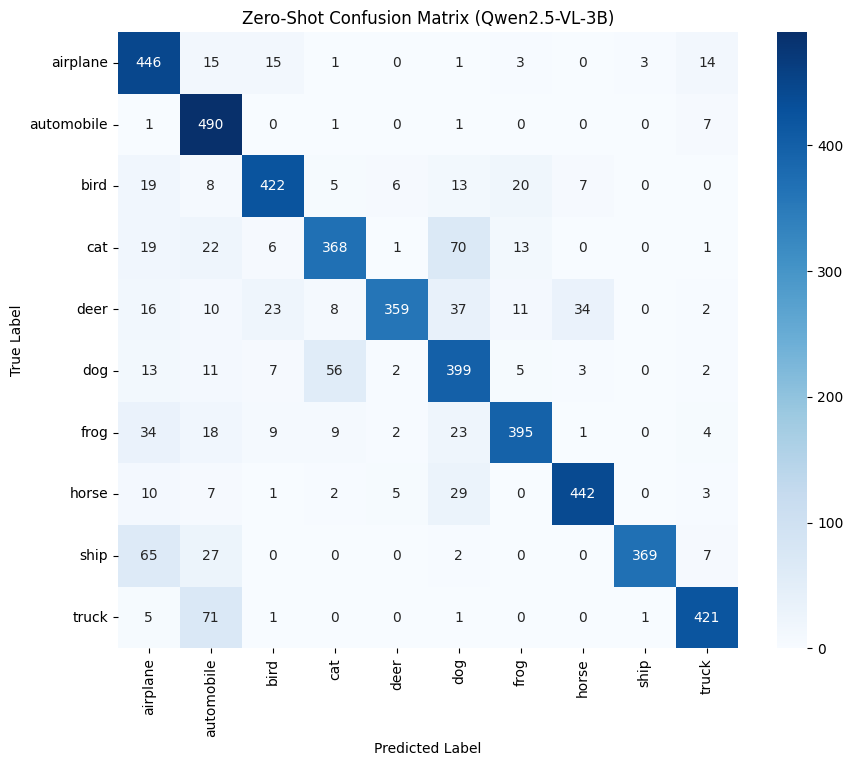

In [10]:
print("\n\n" + "="*50)
print("--- 5. Performance Metrics ---")
print("="*50)

if total_samples > 0:
    accuracy = (correct_predictions / total_samples) * 100
    print(f"Total Samples Tested (50 per class): {total_samples}")
    print(f"Correct Predictions:  {correct_predictions}")
    print(f"Zero-Shot Accuracy:   {accuracy:.2f}%\n")

    # A. Display Classification Report (Precision, Recall, F1-Score)
    print("--- Classification Report ---")
    print(classification_report(all_expected_labels, all_predicted_labels, labels=candidate_labels, zero_division=0))

    # B. Plot Confusion Matrix
    print("\n--- Confusion Matrix ---")

    # Generate the confusion matrix
    cm = confusion_matrix(all_expected_labels, all_predicted_labels, labels=candidate_labels)

    # Plotting using seaborn and matplotlib
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=candidate_labels,
        yticklabels=candidate_labels
    )
    plt.title('Zero-Shot Confusion Matrix (Qwen2.5-VL-3B)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("No samples were tested.")